# basic chatbot with langsmith and API calls

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END 
from langgraph.graph.message import add_messages

In [2]:
import os 
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import AzureChatOpenAI
from langchain_groq import ChatGroq

llm_open_ai=AzureChatOpenAI(
    azure_deployment='gpt-4o',
    api_key=os.getenv('AZURE_OPENAI_GPT_4O_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_GPT_4O_API_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_GPT_4O_API_VERSION')
)

llm_groq=ChatGroq(model='deepseek-r1-distill-llama-70b',api_key=os.getenv('GROQ_API'))

In [3]:
import requests 
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=TSLA&interval=5min&apikey=F2UL8228YNAAADKA'
r = requests.get(url)
data = r.json()

print(data)

{'Meta Data': {'1. Information': 'Intraday (5min) open, high, low, close prices and volume', '2. Symbol': 'TSLA', '3. Last Refreshed': '2025-07-11 19:55:00', '4. Interval': '5min', '5. Output Size': 'Compact', '6. Time Zone': 'US/Eastern'}, 'Time Series (5min)': {'2025-07-11 19:55:00': {'1. open': '312.7200', '2. high': '312.8000', '3. low': '312.5500', '4. close': '312.8000', '5. volume': '51415'}, '2025-07-11 19:50:00': {'1. open': '312.8012', '2. high': '312.8700', '3. low': '312.7000', '4. close': '312.7100', '5. volume': '20205'}, '2025-07-11 19:45:00': {'1. open': '312.8300', '2. high': '312.9000', '3. low': '312.7200', '4. close': '312.8200', '5. volume': '9113'}, '2025-07-11 19:40:00': {'1. open': '312.7400', '2. high': '312.9000', '3. low': '312.7000', '4. close': '312.8300', '5. volume': '23944'}, '2025-07-11 19:35:00': {'1. open': '312.8699', '2. high': '312.8800', '3. low': '312.7000', '4. close': '312.7100', '5. volume': '22841'}, '2025-07-11 19:30:00': {'1. open': '312.87

# workflow with tools 

In [38]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry
from langchain.tools import tool

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

@tool 
def get_weather_data(lat,long,today,tomorrow):
    """ 
    from the given location get the weather forecast by sending the latitude and longitude
    consider today as todays date(check tavily for todays date) and tomorrow as 10 days into the future
    """
    url = "https://archive-api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": long,
        "start_date": today,
        "end_date": tomorrow,
        "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "precipitation", "rain", "weather_code", "wind_speed_10m", "wind_speed_100m", "wind_gusts_10m", "cloud_cover"],
        "timezone": "GMT",
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "timeformat": "unixtime"
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
    hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
    hourly_rain = hourly.Variables(4).ValuesAsNumpy()
    hourly_weather_code = hourly.Variables(5).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(6).ValuesAsNumpy()
    hourly_wind_speed_100m = hourly.Variables(7).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(8).ValuesAsNumpy()
    hourly_cloud_cover = hourly.Variables(9).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True).tz_convert("America/Chicago"),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True).tz_convert("America/Chicago"),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}

    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
    hourly_data["dew_point_2m"] = hourly_dew_point_2m
    hourly_data["precipitation"] = hourly_precipitation
    hourly_data["rain"] = hourly_rain
    hourly_data["weather_code"] = hourly_weather_code
    hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
    hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
    hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
    hourly_data["cloud_cover"] = hourly_cloud_cover
    
    hourly_dataframe = pd.DataFrame(data = hourly_data)
    hourly_dataframe["day"] = hourly_dataframe["date"].dt.day
    hourly_dataframe["hour"] = hourly_dataframe["date"].dt.hour
    hourly_dataframe["year"] = hourly_dataframe['date'].dt.year
    hourly_dataframe['month']=hourly_dataframe['date'].dt.month
    hourly_dataframe['date_UTC']=pd.to_datetime(hourly_dataframe['date'], utc=True)
    return hourly_dataframe

In [ ]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_tavily import TavilySearch 
from langgraph.checkpoint.memory import MemorySaver 
from langchain.tools import tool
class State(TypedDict):
    messages: Annotated[list,add_messages]


def chatbot(state:State):
    return {'messages':[llm_open_ai.invoke(state['messages'])]}

@tool 
def vantage_API(symbol:str)->str:
    """
    Get the most recent CLOSE price of a stock (e.g., IBM, AAPL).
    """
    url = (
        f"https://www.alphavantage.co/query?"
        f"function=TIME_SERIES_INTRADAY&symbol={symbol.upper()}&interval=5min&apikey={os.getenv('VANTAGE_API_KEY')}"
    )
    try:
        response=requests.get(url)
        data=response.json()
        return data
    except Exception as e:
        return f"Error fetching stock data: {str(e)}"
    
tool=TavilySearch(max_results=2)
tools=[tool,vantage_API,get_weather_data]
llm_wth_tools=llm_open_ai.bind_tools(tools)

# node 
memory=MemorySaver()
def tool_calling_llm(state:State):
    return {'messages':[llm_wth_tools.invoke(state['messages'])]}


# create a graph 
builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode(tools))
builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',tools_condition)
builder.add_edge('tools','tool_calling_llm')
graph=builder.compile()

In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults
def search_tavily(query:str)->str:
    """ 
    search the web using Tavility API and return summzarizer results
    """
    try:
        tool = TavilySearchResults(k=3)
        results = tool.run(query)
        return results if results else "No relevant search results found."
    except Exception as e:
        return f"Search failed due to: {str(e)}"
search_tavily('whats the latest Ai news')

C:\Users\26amr\AppData\Local\Temp\ipykernel_47556\297344702.py:7: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(k=3)


[{'title': 'The latest AI news we announced in June - Google Blog',
  'url': 'https://blog.google/technology/ai/google-ai-updates-june-2025/',
  'content': '# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researchers better understand the human genome.\n\nSuperG\n\n## Basic explainer [...] a text card reading "AI to revolutionize scientific discovery"\n\nWe introduced AlphaGenome: AI to better understand the human genome. Our new, unifying DNA sequence model advances regulatory variant-effect prediction and promises to shed new light on genome function. To advance scientific research, we’re making AlphaGenome available in preview via our AlphaGenome API for non-commercial research, with plans to release the model in the future. [...] Search finds new voice, and photos bright,  \nWhile Chromebooks

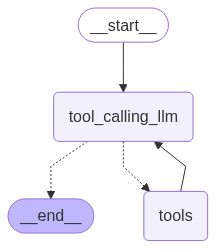

In [40]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png())) 


In [44]:
# config={'configurable':{'thread_id':'1'}}
response=graph.invoke({'messages':'based on the latest tesla news and stock closing price should i invest in tesla?'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

based on the latest tesla news and stock closing price should i invest in tesla?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_2epiXeXd6pbvQcvidfiCbQw1)
 Call ID: call_2epiXeXd6pbvQcvidfiCbQw1
  Args:
    query: latest Tesla news
    search_depth: advanced
    time_range: day
    topic: news
  vantage_API (call_HXYZAzsedoVtRmm8Zi5YZIvC)
 Call ID: call_HXYZAzsedoVtRmm8Zi5YZIvC
  Args:
    symbol: TSLA
================================= Tool Message =================================
Name: tavily_search

{"query": "latest Tesla news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.teslarati.com/tesla-debuts-grok-ai-update-2025-26-what-you-need-to-know/", "title": "Tesla debuts hands-free Grok AI with update 2025.26: What you need to know - Teslarati", "score": 0.7023877, "published_date": "Sat, 12

In [ ]:
# config={'configurable':{'thread_id':'1'}}
response=graph.invoke({'messages':'what is the latest news on bitcoin and what is bitcoin latest close price? should i invest in this?'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the latest news on bitcoin and what is bitcoin latest close price? should i invest in this?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_KWf5tCnI9KTK64EVtGLQkfgK)
 Call ID: call_KWf5tCnI9KTK64EVtGLQkfgK
  Args:
    query: latest news on Bitcoin
    search_depth: basic
    time_range: day
    topic: news
  vantage_API (call_IZMZT0zXAeaDQpRXBMubBTkJ)
 Call ID: call_IZMZT0zXAeaDQpRXBMubBTkJ
  Args:
    symbol: BTC
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news on Bitcoin", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.greenwichtime.com/business/article/bitcoin-tops-118-000-for-the-first-time-and-20765846.php", "title": "Bitcoin tops $118,000 for the first time, as the cryptocurrency continues to climb to new h

In [ ]:
response=graph.invoke({'messages':'is the tesla price falling?'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

is the tesla price falling?
================================== Ai Message ==================================
Tool Calls:
  vantage_API (call_XZGsypOyMLnJYXcUy9ue6UoL)
 Call ID: call_XZGsypOyMLnJYXcUy9ue6UoL
  Args:
    symbol: TSLA
================================= Tool Message =================================
Name: vantage_API

{"Meta Data": {"1. Information": "Intraday (5min) open, high, low, close prices and volume", "2. Symbol": "TSLA", "3. Last Refreshed": "2025-07-11 19:55:00", "4. Interval": "5min", "5. Output Size": "Compact", "6. Time Zone": "US/Eastern"}, "Time Series (5min)": {"2025-07-11 19:55:00": {"1. open": "312.7200", "2. high": "312.8000", "3. low": "312.5500", "4. close": "312.8000", "5. volume": "51415"}, "2025-07-11 19:50:00": {"1. open": "312.8012", "2. high": "312.8700", "3. low": "312.7000", "4. close": "312.7100", "5. volume": "20205"}, "2025-07-11 19:45:00": {"1. open": "312.8300